In [21]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## load data
path = '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/phenotype_file/release_36K/'
ADNI = pd.read_csv(path + "ADNIPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
family_based = pd.read_csv(path + "ADSPFamilyBasedPhenotypes_DS_2022.08.18_ALL.txt", sep='\t',encoding='cp1252')
case_control = pd.read_csv(path + "ADSPCaseControlPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
PSPCBD = pd.read_csv(path + "PSPCBDPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
SUBJ_drop = pd.read_excel(path + 'ng00067_subject_droplist_2022.08.18.xlsx', engine = 'openpyxl')
PSPCBD_descript = pd.read_excel(path + 'PSPCBDPhenotypes_DD_2022.08.18.xlsx', engine = 'openpyxl')
vcf = pd.read_csv(path + 'vcf_ids.txt', sep = '\t')
manifest = pd.read_csv(path + "SampleManifest_DS_2022.08.18_ALL.txt", sep='\t') ## the one with mapping info

qc = pd.read_csv(path+"gcad.qc.r4.wgs.allchr.36361.GATK.2022.08.15.sample.summary.ALL.txt", sep = '\t') ## this one contains QC info( all the sampleID here are WGS)
ibd = pd.read_csv(path + 'gcad.r4.wgs.36361.2022.08.15.pairwise_IBD.txt', sep = '\t')

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
## SUBJID and SampleID are not 1-1 match
print(len(manifest.SUBJID.unique()))
print(len(manifest.SampleID.unique()))

51992
56863


## deal with pheno_merge

In [4]:
print(ADNI.shape, family_based.shape, case_control.shape, PSPCBD.shape)

(1566, 31) (12858, 27) (45375, 31) (2803, 17)


### ADNI

In [6]:
ADNI_processed = ADNI.loc[:,['SUBJID', 'Sex', 'PrevAD', 'IncAD','Age_current', 'Age_MCI_onset','Age_AD_onset', 'Age_baseline','APOE_reported','Race', 'AD_last_visit', 'Ethnicity']]
ADNI_processed["Diagnosis"] = ADNI_processed.AD_last_visit

#ADNI_processed.loc[(ADNI_processed["Age_MCI_onset"].notnull())& (ADNI_processed["Diagnosis"] ==0)]  #528
#ADNI_processed = ADNI_processed.drop(ADNI_processed[(ADNI_processed["Age_MCI_onset"].notnull()) & (ADNI_processed["Diagnosis"] == 0)].index)

ADNI_processed["Age"] = ADNI_processed.Age_current
ADNI_processed.loc[ADNI_processed.Diagnosis == 1,'Age'] = ADNI_processed.loc[ADNI_processed.Diagnosis == 1,'Age_AD_onset']  ## changed the age to age of onset of they are AD cases

print(ADNI_processed.value_counts('Diagnosis'))
ADNI_processed.shape

Diagnosis
0    958
1    608
dtype: int64


(1566, 14)

In [7]:
## There are two cases without age of onset, set them to Age_current
## all controls have current age and the age they first entered the study!
ADNI_processed[ADNI_processed.Age.isnull()]


,SUBJID,Sex,PrevAD,IncAD,Age_current,Age_MCI_onset,Age_AD_onset,Age_baseline,APOE_reported,Race,AD_last_visit,Ethnicity,Diagnosis,Age
871,G-ADNI-AN000064,0,0,1,66,60,NaN,61,33,5.0,1,0.0,1,NaN
975,G-ADNI-AN000170,0,0,1,76,71,NaN,73,34,5.0,1,0.0,1,NaN


In [8]:
ADNI_processed.loc[ADNI_processed.Age.isnull(), 'Age'] = ADNI_processed.Age_current
ADNI_processed[ADNI_processed.Age.isnull()]

,SUBJID,Sex,PrevAD,IncAD,Age_current,Age_MCI_onset,Age_AD_onset,Age_baseline,APOE_reported,Race,AD_last_visit,Ethnicity,Diagnosis,Age


### family_based

In [9]:
family_based['Diagnosis'] = np.nan
family_based.loc[family_based['AD'] == 0, "Diagnosis"] = 0
family_based.loc[(family_based['AD'] >=1) & (family_based['AD'] <=3), "Diagnosis"] =1
family_based.Diagnosis.value_counts(dropna=False)

NaN    8507
0.0    2493
1.0    1858
Name: Diagnosis, dtype: int64

### case_control

In [10]:
case_control.AD = case_control.AD.astype('Int64')
case_control_processed = case_control.rename(columns = {'AD':'Diagnosis'})
print(case_control_processed.Diagnosis.value_counts(dropna=False))
#case_control_processed = case_control_processed.dropna(subset = ['Diagnosis','Age', 'APOE_reported', 'Race'])

0      23347
1      16793
NaN     5235
Name: Diagnosis, dtype: Int64


### merge

In [11]:
ADNI_processed["source"] = 'ADNI'
family_based["source"] = 'Family_based'
case_control_processed["source"] = 'case_control'

pheno = pd.concat([ADNI_processed, family_based, case_control_processed])
pheno.loc[pheno['Age'] == '90+', 'Age'] = 90
pheno.loc[pheno['Age_baseline'] == '90+', 'Age_baseline'] = 90
#pheno.Age = pheno.Age.astype('int')
print(pheno.shape)
pheno.Diagnosis.value_counts(dropna=False)

(59799, 43)


0.0    26798
1.0    19259
NaN    13742
Name: Diagnosis, dtype: int64

In [12]:
## Only keep WGS
wgs_SUBJID = manifest[manifest.SampleID.isin(qc.SampleID)].SUBJID
print(wgs_SUBJID.shape)

print('before extracting WGS', pheno.shape)
pheno = pheno[pheno.SUBJID.isin(wgs_SUBJID)]

print('After extracting WGS', pheno.shape)

(36361,)
before extracting WGS (59799, 43)
After extracting WGS (33639, 43)


In [13]:
## drop technique replicates (using SUBJID)
replicate_to_drop = manifest[(manifest.SampleID.isin(qc.SampleID)) & (manifest.Technical_Replicate == 1)] ##(63,10)
print(pheno[pheno.SUBJID.isin(replicate_to_drop.SUBJID)].shape)
pheno = pheno[~pheno.SUBJID.isin(replicate_to_drop.SUBJID)]
pheno.shape

(6, 43)


(33633, 43)

In [14]:
duplicated_ID = pheno[pheno.SUBJID.duplicated()].SUBJID
print(duplicated_ID.shape, pheno.shape)

## The duplicates are between family based and case control, two as a pair
print(min(pheno[pheno.SUBJID.isin(duplicated_ID)].value_counts('SUBJID')))
print(max(pheno[pheno.SUBJID.isin(duplicated_ID)].value_counts('SUBJID')))

duplicates = pheno[pheno.SUBJID.isin(duplicated_ID)].sort_values('SUBJID', ascending = False)
print(pheno[pheno.SUBJID.duplicated()].source.unique()) ### they are all case_control
pheno = pheno[~pheno.SUBJID.duplicated()] ## only keep the family_based one
print(pheno.shape)
pheno.to_csv(path + 'check_pheno.tsv',sep = '\t', index = False)

(32,) (33633, 43)
2
2
['case_control']
(33601, 43)


In [15]:
print(len(pheno.SUBJID.unique()))
print(pheno.Diagnosis.value_counts(dropna=False))
#pheno = pheno[["SUBJID", "Sex", "Diagnosis", "APOE_reported","Age","Race","Ethnicity","FamID",'source']]

33601
0.0    17386
1.0    11561
NaN     4654
Name: Diagnosis, dtype: int64


<AxesSubplot:title={'center':'data surce for pheno_merge'}>

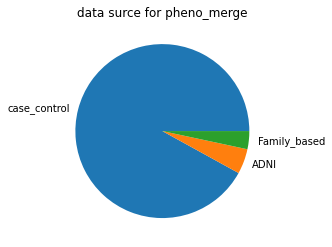

In [16]:
pheno.source.value_counts().plot(kind='pie', ylabel='', title='data surce for pheno_merge')

## manifest & IBD & QC

In [17]:
 ## every SampleID is unique, and they might map to the same SUBJID
print(manifest.shape)
print(len(manifest.SUBJID.unique()))
print(len(manifest.SampleID.unique()))

(56863, 10)
51992
56863


In [18]:
## Manifest
pheno_add_SampleID  = pheno.merge(manifest, on="SUBJID")
print(pheno_add_SampleID.shape)
dup_sample = pheno_add_SampleID[pheno_add_SampleID.SUBJID.duplicated(keep=False)] #9033 row

dup_SampleID = manifest[manifest.SUBJID.isin(dup_sample.SUBJID.unique())].SampleID ##9033
print(qc[qc.SampleID.isin(dup_SampleID)].Missing.idxmin())
dup_SampleID[~dup_SampleID.isin(qc.SampleID)]  ## not every SampleID is found in QC file

## extract the SampleID with the lowest missing num
best_SampleID=[]
for i in dup_sample.SUBJID.unique():
    SampleID = manifest[manifest.SUBJID==i].SampleID
    best_id = qc[qc.SampleID.isin(SampleID)].Missing.idxmin()
    best_SampleID.append(qc.loc[best_id].SampleID)
    

(38133, 52)
22552


In [19]:
pheno_add_SampleID  = pheno.merge(manifest, on="SUBJID")
print(pheno_add_SampleID.shape)
dup_sample = pheno_add_SampleID[pheno_add_SampleID.SUBJID.duplicated(keep=False)] #9033 row

dup_SampleID = manifest[manifest.SUBJID.isin(dup_sample.SUBJID.unique())].SampleID ##9033
print(pheno_add_SampleID[['Sex','Ethnicity','Race']].isnull().sum())

(38133, 52)
Sex             1
Ethnicity     860
Race         2747
dtype: int64


In [20]:
## create a dict for SUBJID-SampleID mapping 
print(len(best_SampleID))
print(len(dup_sample.SUBJID.unique()))
map_sampleID = dict(list(zip(dup_sample.SUBJID.unique(), best_SampleID)))

pheno_SampleID_todrop = pheno_add_SampleID[pheno_add_SampleID.SUBJID.isin(map_sampleID)]
pheno_SampleID_todrop[pheno_SampleID_todrop.SampleID != pheno_SampleID_todrop.SUBJID.map(map_sampleID)]

4501
4501


,SUBJID,Sex,PrevAD,IncAD,Age_current,Age_MCI_onset,Age_AD_onset,Age_baseline,APOE_reported,Race,...,Update_Latest,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
1973,A-CUHS-CU006133,1.0,NaN,NaN,NaN,NaN,NaN,58,44.0,6.0,...,NaN,A-CUHS-CU006133-BL-COL-31008BL1,Blood,DNA,WashU,Illumina_HiSeqX,WGS,0,sa000001,snd10001
2001,A-LOAD-LD001135,1.0,NaN,NaN,NaN,NaN,NaN,79,33.0,5.0,...,NaN,A-LOAD-LD001135-BL-NCR-8008285337,Blood,DNA,Otogenetics,Illumina_HiSeq_2000,WES,0,sa000004,snd10004
2016,A-LOAD-LD001340,1.0,NaN,NaN,NaN,NaN,NaN,82,23.0,5.0,...,NaN,A-LOAD-LD001340-CL-NCR-07AD1620,Cell Line,DNA,UW_GenomeSciences,Illumina_HiSeq_2000,WES,0,sa000005,snd10005
2020,A-LOAD-LD001349,1.0,NaN,NaN,NaN,NaN,NaN,90,33.0,5.0,...,NaN,A-LOAD-LD001349-UNK-NCR-11AD47531,Unknown,DNA,UW_GenomeSciences,Illumina_HiSeq_2000,WES,0,sa000005,snd10005
2068,A-LOAD-LD004376,0.0,NaN,NaN,NaN,NaN,NaN,71,33.0,5.0,...,NaN,A-LOAD-LD004376-UNK-UNK-UNK0036,Unknown,DNA,GENENTECH,Illumina_HiSeq_2000,WGS,0,sa000004,snd10018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35045,G-KGAD-KA001216,1.0,1.0,0.0,NaN,NaN,NaN,70,34.0,5.0,...,1.0,G-KGAD-KA000886-BL-WU-8038741275,Blood,DNA,USUHS,Illumina_NovaSeq,WGS,0,sa000023,snd10032
37811,G-MSBB-MB000022,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,5.0,...,0.0,G-MSBB-MB000022-BR-MSBB-71813,Brain,DNA,NYGC,Illumina_HiSeqX,WGS,0,sa000011,snd10011
37884,G-MSBB-MB000094,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,5.0,...,0.0,G-MSBB-MB000094-BR-MSBB-71738,Brain,DNA,NYGC,Illumina_HiSeqX,WGS,0,sa000011,snd10011
37917,G-MSBB-MB000126,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,5.0,...,0.0,G-MSBB-MB000126-BR-MSBB-71926,Brain,DNA,NYGC,Illumina_HiSeqX,WGS,0,sa000011,snd10011


In [45]:
pheno_add_SampleID = pheno_add_SampleID.drop(pheno_SampleID_todrop[pheno_SampleID_todrop.SampleID != pheno_SampleID_todrop.SUBJID.map(map_sampleID)].index)  ## got back to 33601 (everyone is one-to-one match)
pheno_add_SampleID.shape
#pheno_add_SampleID.to_csv(path +'pheno_sampleID.tsv',sep = '\t', index = False)

(33681, 52)

## check King

In [21]:
#king_manifest = pd.read_csv(path+'pheno_merge_sampleID_king.tsv', sep = '\t')
print(pheno_add_SampleID['source'].value_counts())
king = np.loadtxt("/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/phenotype_file/release_36K/unrelated_samples.txt", dtype=str) ## The non-related individual's sample ID calculate from Kinship only have sample ID
pheno_king = pheno_add_SampleID[pheno_add_SampleID.SampleID.isin(king)] ## 31351

pheno_king['source'].value_counts()

case_control    35339
ADNI             1566
Family_based     1228
Name: source, dtype: int64


case_control    29718
ADNI             1378
Family_based      568
Name: source, dtype: int64

In [22]:
family = pheno_king[pheno_king.source=='Family_based']  ## they have 1114, we have 568

# Randomly shuffle the rows of the DataFrame
families = family.sample(frac=1)

# Sort the DataFrame by 'Diagnosis' column, group by 'FamID', select the first row in each group, and reset the index
one_per_fam = families.sort_values(by='Diagnosis', ascending=False)\
                     .groupby('FamID', sort=False)\
                     .head(1)\
                     .reset_index(drop=True)


In [23]:
pheno_fin = pd.concat([pheno_king[pheno_king.source!='Family_based'],one_per_fam])
print(pheno_fin.shape)
print(pheno_fin["Diagnosis"].value_counts(dropna=False))

(31357, 52)
0.0    16214
1.0    10792
NaN     4351
Name: Diagnosis, dtype: int64


In [24]:
pheno_fin = pheno_fin[pheno_fin.Diagnosis.notnull()] ## 26726, remove the NAs

In [25]:
pheno_fin[['Sex','Ethnicity','Race','APOE_WGS','Diagnosis','Age']].isnull().sum()

Sex             0
Ethnicity     577
Race         2680
APOE_WGS     1719
Diagnosis       0
Age           672
dtype: int64

In [27]:
Age_null = pheno_fin[pheno_fin['Age'].isnull()].SUBJID
Age_null.shape

(672,)

In [28]:
print(pheno[pheno.SUBJID.isin(Age_null)].Age_current.isnull().sum())
pheno.loc[pheno.SUBJID.isin(Age_null),["source",'Age_current','Diagnosis','SUBJID']]


672


,source,Age_current,Diagnosis,SUBJID
12244,Family_based,NaN,0,A-RAS-RA000188
1441,case_control,NaN,1,A-ADC-AD000091
1462,case_control,NaN,1,A-ADC-AD000125
1465,case_control,NaN,1,A-ADC-AD000132
1475,case_control,NaN,1,A-ADC-AD000144
...,...,...,...,...
42347,case_control,NaN,0,G-KGAD-KA001271
42348,case_control,NaN,0,G-KGAD-KA001272
42349,case_control,NaN,0,G-KGAD-KA001273
42350,case_control,NaN,0,G-KGAD-KA001274


In [29]:
pheno_fin = pheno_fin.dropna(subset=['Age']) ##26334
pheno_fin = pheno_fin[['SUBJID','SampleID', 'Sex', 'Diagnosis', 'APOE_reported', 'Age', 'Race',
       'Ethnicity', 'FamID', 'source']]
pheno_fin.shape
pheno_fin.Age = pheno_fin.Age.astype('int64')

(26334, 10)

In [42]:
pheno_fin.to_csv(path +'pheno_fin.tsv',sep = '\t', index = False) 

<AxesSubplot:title={'center':'pheno_fin'}>

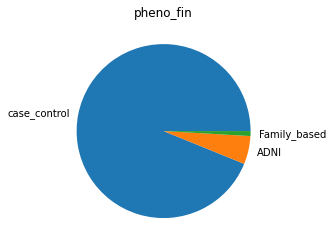

In [60]:
pheno_fin.source.value_counts().plot(kind='pie', ylabel='', title='pheno_fin')

In [33]:
pheno_fin.source.value_counts()

case_control    24715
ADNI             1378
Family_based      241
Name: source, dtype: int64

In [34]:
pheno_fin.Diagnosis.value_counts()

0    15924
1    10410
Name: Diagnosis, dtype: int64

In [44]:
pheno_fin_LOAD = pheno_fin[pheno_fin.Age >= 65]
pheno_fin_LOAD.to_csv(path +'pheno_fin_LOAD.tsv',sep = '\t', index = False) 

<AxesSubplot:ylabel='Density'>

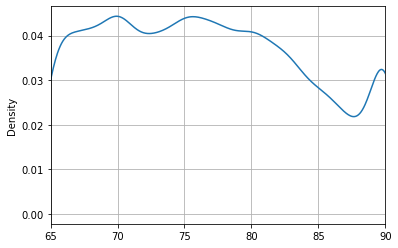

In [55]:
pheno_fin_LOAD.Age.plot(kind='kde', xlim=(65,90), grid=True, xlabel='Age')

<AxesSubplot:ylabel='Density'>

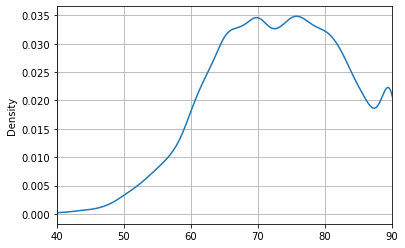

In [58]:
pheno_fin.Age.plot(kind='kde',  xlim=(40,90), grid=True, xlabel='Age')

<AxesSubplot:title={'center':'pheno_LOAD'}>

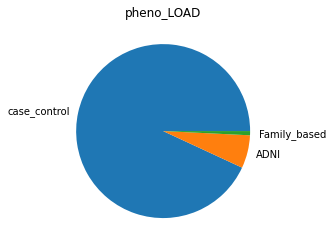

In [61]:
pheno_fin_LOAD.source.value_counts().plot(kind='pie', ylabel='', title='pheno_LOAD')

In [62]:
pheno_fin_LOAD.source.value_counts()

case_control    19504
ADNI             1285
Family_based      162
Name: source, dtype: int64

In [35]:
pheno_fin_LOAD.Race.value_counts()

5.0    9979
4.0    3959
6.0    3387
2.0    1983
1.0      60
3.0       6
Name: Race, dtype: int64

In [66]:
print(pheno_fin.Diagnosis.value_counts())
print(pheno_fin.Race.value_counts())


0    15924
1    10410
Name: Diagnosis, dtype: int64
5.0    12602
4.0     4529
6.0     3671
2.0     2754
1.0       91
3.0        9
Name: Race, dtype: int64


In [220]:
path = '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/phenotype_file/release_36K/'
pheno_fin_LOAD = pd.read_csv(path +'pheno_fin_LOAD.tsv',sep = '\t')
pheno_fin = pd.read_csv(path +'pheno_fin.tsv',sep = '\t')

In [3]:
pheno_fin_LOAD.source

0                ADNI
1                ADNI
2                ADNI
3                ADNI
4                ADNI
             ...     
20946    Family_based
20947    Family_based
20948    Family_based
20949    Family_based
20950    Family_based
Name: source, Length: 20951, dtype: object

In [5]:
pheno_fin_LOAD.Ethnicity.value_counts()

0.0    13860
1.0     6697
Name: Ethnicity, dtype: int64

In [6]:
pheno_fin_LOAD.groupby('Ethnicity')['Race'].value_counts()

Ethnicity  Race
0.0        5.0     8118
           4.0     3722
           2.0     1954
           1.0       36
           6.0       17
           3.0        3
1.0        6.0     3355
           5.0     1561
           4.0      165
           2.0       26
           1.0       21
           3.0        3
Name: Race, dtype: int64

In [117]:
pheno_fin.groupby('Ethnicity')['Race'].value_counts()

Ethnicity  Race
0.0        5.0     10072
           4.0      4232
           2.0      2705
           1.0        52
           6.0        20
           3.0         6
1.0        6.0      3631
           5.0      2101
           4.0       193
           2.0        45
           1.0        33
           3.0         3
Name: Race, dtype: int64

In [119]:
index_mapping = {
    1.0: 'Indian/Alaska',
    2.0: 'Asian',
    3.0: 'Pacific Islander',
    4.0: 'Black',
    5.0: 'White',
    6.0: 'Other'
}

In [133]:
race = pheno_fin_LOAD.Race.value_counts()
ratio = pheno_fin_LOAD.loc[pheno_fin_LOAD['Ethnicity'] == 1, 'Race'].value_counts()/pheno_fin_LOAD.Race.value_counts()
ratio_percentage = ratio*100
#ratio_percentage = ratio_percentage.rename(index=index_mapping)

In [167]:
his_count = pheno_fin_LOAD.loc[pheno_fin_LOAD['Ethnicity'] == 1,'Race'].value_counts()
pheno_hispanic = pd.DataFrame({'Ratio': ratio_percentage, 'Race':race,'Hispanic': his_count})
pheno_hispanic = pheno_hispanic.rename(index=index_mapping)
pheno_hispanic

,Ratio,Race,Hispanic
Indian/Alaska,35.000000,60,21
Asian,1.311145,1983,26
Pacific Islander,50.000000,6,3
Black,4.167719,3959,165
White,15.642850,9979,1561
Other,99.055211,3387,3355


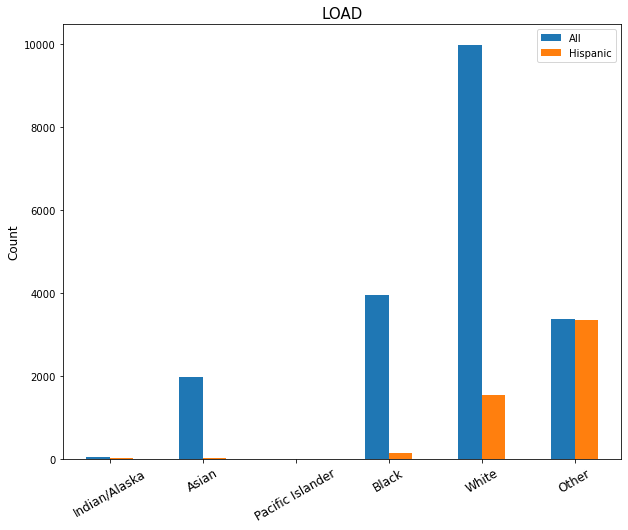

In [197]:
pheno_hispanic[['Race','Hispanic']].plot.bar(figsize=(10,8))
plt.ylabel('Count', size=12)
plt.xticks(rotation=30, size = 12)
plt.title('LOAD', size = 15)
plt.legend(labels=['All','Hispanic'])

AxesSubplot(0.125,0.125;0.775x0.755)


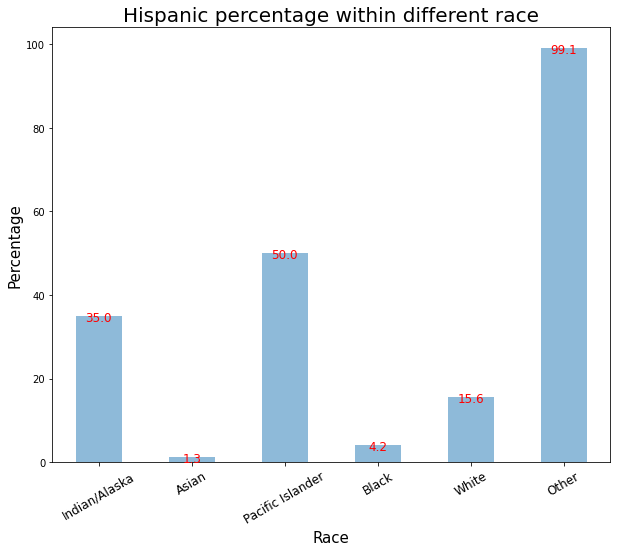

In [192]:
ax = pheno_hispanic.Ratio.plot.bar(alpha=0.5,figsize=(10,8))
for i, value in enumerate(ratio_percentage):
    ax.text(i, value, f'{value:.1f}', ha='center', va='center_baseline', color='red', fontsize='large')
plt.xticks(rotation=30, size=12)
plt.title('Hispanic percentage within different race',size=20)
plt.ylabel('Percentage', size=15)
plt.xlabel('Race', size=15)
print(ax)

In [229]:
## Create pheno with His count
pheno_fin['fin_population_temp']='NA'
pheno_fin.loc[(pheno_fin.Race == 6) & (pheno_fin.Ethnicity == 1),'fin_population_temp']='AMR'
pheno_fin.loc[(pheno_fin.Race.isna()) & (pheno_fin.Ethnicity == 1),'fin_population_temp']='AMR'

In [235]:
pheno_fin.fin_population_temp.value_counts()

NA     22703
AMR     3631
Name: fin_population_temp, dtype: int64

In [236]:
## Assign race
pheno_fin.loc[(pheno_fin.Race == 5) & (pheno_fin.Ethnicity == 0),'fin_population_temp']='EUR'
pheno_fin.loc[(pheno_fin.Race == 5) & (pheno_fin.Ethnicity == 1),'fin_population_temp']='HIS_WHITE'
pheno_fin.loc[(pheno_fin.Race == 2),'fin_population_temp']='ASN'
pheno_fin.loc[(pheno_fin.Race == 4),'fin_population_temp']='AFR'

In [256]:
pheno_fin.fin_population_temp.value_counts()

EUR          10072
AMR           6292
AFR           4529
ASN           2754
HIS_WHITE     2101
NA             586
Name: fin_population_temp, dtype: int64

In [257]:
pheno_fin[pheno_fin.fin_population_temp=='NA'].groupby('Ethnicity',dropna=False)['Race'].value_counts(dropna=False)

Ethnicity  Race
0.0        1.0      52
           6.0      20
           NaN      14
           3.0       6
1.0        1.0      33
           3.0       3
NaN        5.0     429
           6.0      20
           1.0       6
           NaN       3
Name: Race, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


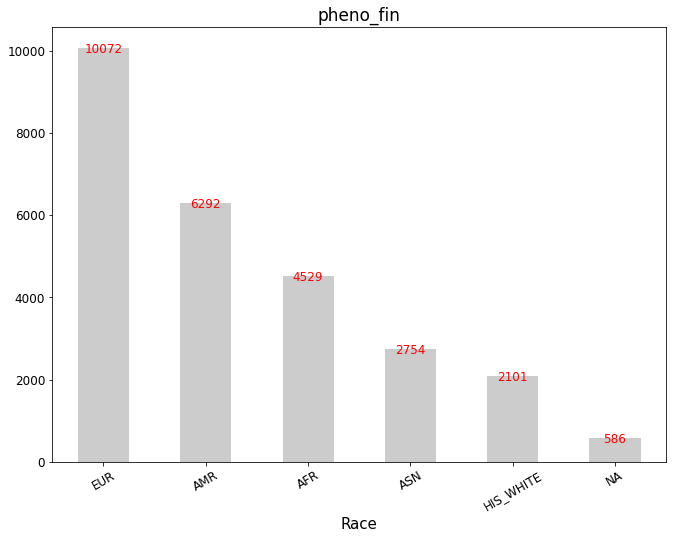

In [285]:
ax = pheno_fin.fin_population_temp.value_counts().plot.bar(color='grey',alpha=0.4,figsize=(11,8))
for i, value in enumerate(pheno_fin.fin_population_temp.value_counts()):
    ax.text(i, value, value, ha='center', va='center_baseline', color='red', fontsize='large')
plt.yticks(size=12)
plt.xlabel('Race', size=15)
plt.xticks(rotation=30, size=12)
plt.title('pheno_fin', size=17)
print(ax)

In [283]:
pheno_fin

,SUBJID,SampleID,Sex,Diagnosis,APOE_reported,Age,Race,Ethnicity,FamID,source,fin_population_temp
0,ADNI_002_S_0685,ADNI_002_S_0685,1.0,0.0,33.0,90,5.0,0.0,NaN,ADNI,EUR
1,ADNI_002_S_1155,ADNI_002_S_1155,0.0,0.0,33.0,69,5.0,0.0,NaN,ADNI,EUR
2,ADNI_002_S_1261,ADNI_002_S_1261,1.0,0.0,33.0,82,5.0,0.0,NaN,ADNI,EUR
3,ADNI_002_S_2010,ADNI_002_S_2010,1.0,0.0,34.0,68,6.0,0.0,NaN,ADNI,NA
4,ADNI_002_S_2073,ADNI_002_S_2073,1.0,0.0,33.0,69,5.0,0.0,NaN,ADNI,EUR
...,...,...,...,...,...,...,...,...,...,...,...
26329,A-CUHS-CU005861,A-CUHS-CU005861-BL-COL-49677BL1,1.0,0.0,33.0,58,6.0,1.0,CU0170F,Family_based,AMR
26330,A-WRAP-WR000875,A-WRAP-WR000875-BL-NCR-104770975,1.0,0.0,33.0,61,5.0,0.0,WR1702F,Family_based,EUR
26331,A-CUHS-CU004425,A-CUHS-CU004425-BL-COL-40853BL1,0.0,0.0,33.0,63,6.0,1.0,CU0149F,Family_based,AMR
26332,A-WRAP-WR000196,A-WRAP-WR000196-BL-NCR-0005966657,1.0,0.0,34.0,64,5.0,0.0,WR1163F,Family_based,EUR


In [284]:
pheno_fin_LOAD = pheno_fin[pheno_fin.Age >= 65]


AxesSubplot(0.125,0.125;0.775x0.755)


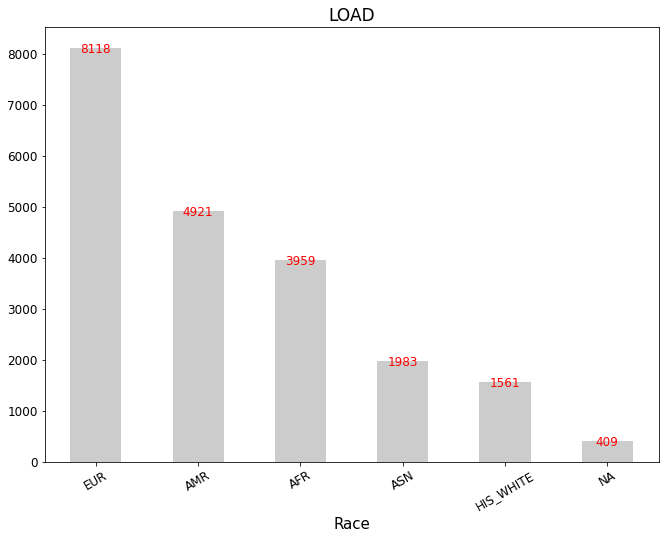

In [287]:
ax = pheno_fin_LOAD.fin_population_temp.value_counts().plot.bar(color='grey',alpha=0.4,figsize=(11,8))
for i, value in enumerate(pheno_fin_LOAD.fin_population_temp.value_counts()):
    ax.text(i, value, value, ha='center', va='center_baseline', color='red', fontsize='large')
plt.yticks(size=12)
plt.xlabel('Race', size=15)
plt.xticks(rotation=30, size=12)
plt.title('LOAD', size=17)
print(ax)

In [288]:
pheno_fin_LOAD.to_csv(path +'pheno_LOAD_redo_his.tsv',sep = '\t', index = False) 
pheno_fin.to_csv(path +'pheno_redo_his.tsv',sep = '\t', index = False) 

In [289]:
pheno_fin_LOAD[pheno_fin_LOAD.SampleID != pheno_fin_LOAD.SUBJID]

,SUBJID,SampleID,Sex,Diagnosis,APOE_reported,Age,Race,Ethnicity,FamID,source,fin_population_temp
704,G-ADNI-AN000001,G-ADNI-AN000001-BL-NCR-11AD41004,1.0,0.0,33.0,79,5.0,0.0,NaN,ADNI,EUR
705,G-ADNI-AN000002,G-ADNI-AN000002-BL-NCR-11AD45783,0.0,0.0,33.0,74,5.0,0.0,NaN,ADNI,EUR
706,G-ADNI-AN000003,G-ADNI-AN000003-BL-NCR-11AD47096,1.0,0.0,22.0,74,5.0,0.0,NaN,ADNI,EUR
707,G-ADNI-AN000004,G-ADNI-AN000004-BL-NCR-12AD50909,1.0,0.0,34.0,78,5.0,0.0,NaN,ADNI,EUR
708,G-ADNI-AN000005,G-ADNI-AN000005-BL-NCR-12AD51206,0.0,1.0,34.0,82,5.0,0.0,NaN,ADNI,EUR
...,...,...,...,...,...,...,...,...,...,...,...
26320,A-CUHS-CU004510,A-CUHS-CU004510-BL-COL-47848BL1,1.0,0.0,33.0,78,6.0,1.0,CU0150F,Family_based,AMR
26322,A-WRAP-WR000077,A-WRAP-WR000077-BL-NCR-0005966509,1.0,0.0,33.0,65,5.0,0.0,WR1057F,Family_based,EUR
26325,A-CUHS-CU002162,A-CUHS-CU002162-BL-COL-49766BL1,1.0,0.0,34.0,75,6.0,1.0,CU0050F,Family_based,AMR
26327,A-LOAD-LD001488,A-LOAD-LD001488-UNK-NCR-05AD8975,0.0,0.0,44.0,81,5.0,0.0,LD0251F,Family_based,EUR
